# Natural Language Processing - Classifying Stars Review by reading Text Review

In this NLP project I will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. 

The dataset I will be using is from [Yelp Review Data Set from Kaggle](https://www.kaggle.com/astandrik/yelp-review).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
%matplotlib inline

# Data
_______________
Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [4]:
raw = pd.read_csv('yelp.csv')
raw.shape

(10000, 10)

In [5]:
raw.head(5)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [7]:
raw.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


The data is already cleaned and there are no missing data. 

I will create a new column for NLP called "text length" which is the number of words in the text column.

In [15]:
raw['text length'] = raw['text'].apply(lambda x: len(x))

# Exploratory Data Analysis
_______________

**Let's see how 'stars' are distributed in the data!**

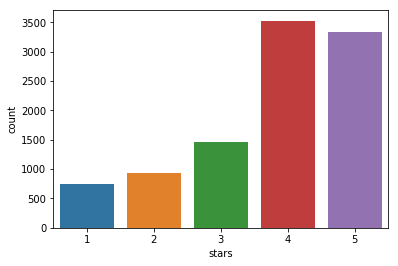

In [20]:
sns.countplot(x='stars', data=raw)

** Relationship between number of 'stars' and 'text length'**

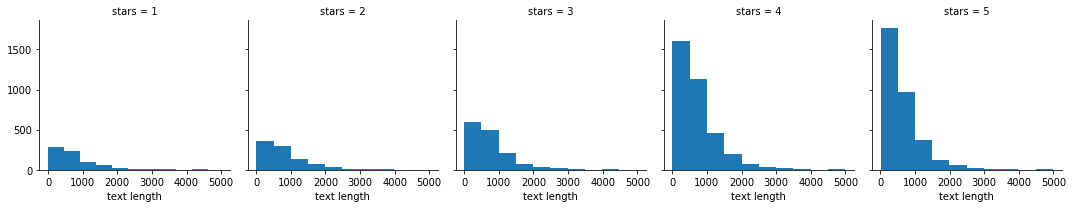

In [17]:
g = sns.FacetGrid(raw,col='stars')
g.map(plt.hist,'text length')

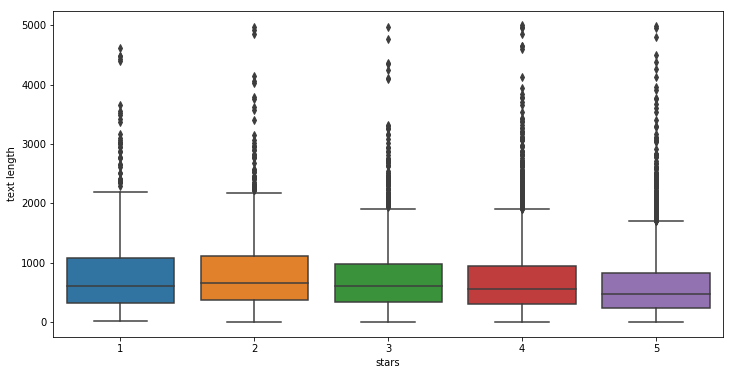

In [19]:
plt.figure(figsize = (12,6))
sns.boxplot(x='stars', y='text length', data = raw)

** Use groupby to get the mean values of the numerical columns, look at correlation:**

In [24]:
stars = raw.groupby('stars').mean()
stars.head()

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [22]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


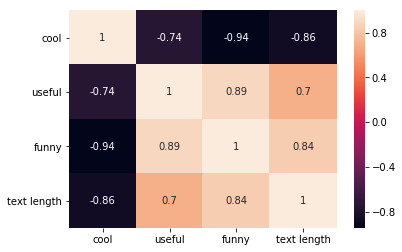

In [25]:
sns.heatmap(data=stars.corr(), annot=True)

# Modeling
________

Let's move on to the actual task. To make things a little easier, I will only use reviews that were either 1 star or 5 stars.

In [88]:
yelp_class = raw[(raw.stars==1) | (raw.stars==5)]
X = yelp_class['text']
y = yelp_class['stars']

**Import CountVectorizer and create a CountVectorizer object.**

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Might take awhile...
CV = CountVectorizer()
X = CV.fit_transform(X)

### Train Test Split

Let's split our data into training and testing data.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

### Training a Model

In [39]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

# fit nb using the training data
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Predictions and Evaluations
_________
Time to see how our model did!

In [40]:
# get the prediction
prediction = nb.predict(X_test)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
# Create a confusion matrix and classification report using predictions and y_test
print (confusion_matrix(y_test, prediction))
print (classification_report(y_test, prediction))

[[159  69]
 [ 22 976]]
             precision    recall  f1-score   support

          1       0.88      0.70      0.78       228
          5       0.93      0.98      0.96       998

avg / total       0.92      0.93      0.92      1226



**Great! Let's see what happens if we try to include TF-IDF to this process using a pipeline.**

# Using Text Processing
_________

In [63]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords ## for list of stopwords
import string  ## for list of punctuations

Let's build a function that will process text to more suitable format.

In [64]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

### Using the Pipeline

In [ ]:
pipeline = Pipeline([
    ('cv', CountVectorizer(analyzer = text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

### Train Test Split

Let's split our data into training and testing data.

In [84]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

### Training a Model

In [85]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer=<function text_process at 0x000001339F7CEAE8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluation

** Now use the pipeline to predict from the X_test and create a classification report and confusion matrix. You should notice strange results.**

In [86]:
predictions = pipeline.predict(X_test)

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
print (confusion_matrix(y_test, predictions))
print (classification_report(y_test, predictions))

[[  0 228]
 [  0 998]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       228
          5       0.81      1.00      0.90       998

avg / total       0.66      0.81      0.73      1226



C:\Users\Gabe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


HUH! Looks like Tf-Idf actually made things worse!

### Possible room for improvements:
* temper with custom analyzer
* try to recreate the pipeline with just the CountVectorizer() and NaiveBayes.